In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Learning Curves

## Unstable curves

There are many reasons that can lead to unstable learning curves:
* the chosen optimizer
* learning rate
* batch-size
* network architecture
* weight initialization
* etc.

All these parameters can be tuned to improve our model learning curves, as we aim for better accuracy and generalization power.

## Can we benefit from more data?

If after using all our data we see that our test still has a tendency to improve, that is, it's not parallel to our training set curve and it's increasing, then it's worth it to gather more data if possible to allow the model to keep learning. 

## Coding train size comparison

We first store the model initial weights, this is done by calling get_weights on our model,we then initialize two lists to store train and test accuracies.

    # Store initial model weights
    init_weights = model.get_weights()
    # Lists for storing accuracies
    train_accs = []
    tests_accs = []

We loop over a predefined list of train sizes and for each training size we get the corresponding training data fraction.

Before any training, we make sure our model starts with the same set of weights by setting them to the initial_weights using the set_weights function.

After that, we can fit our model on the training fraction. We use an EarlyStopping callback which monitors loss,but it's important to note that it's not validation loss since we haven't provided the fit method with validation data.

After the training is done, we can get the accuracy for the training set fraction and the accuracy from the test set and append it to our lists of accuracies.

Observe that the same quantity of test data observations were used to evaluate each iteration. 

    for train_size in train_sizes:
        # Split a fraction according to train_size
        X_train_frac, _, y_train_frac, _ =
        train_test_split(X_train, y_train, train_size=train_size)
        # Set model initial weights
        model.set_weights(initial_weights)
        # Fit model on the training set fraction
        model.fit(X_train_frac, y_train_frac, epochs=100,
                  verbose=0,
        callbacks=[EarlyStopping(monitor='loss', patience=1)])
        # Get the accuracy for this training set fraction
        train_acc = model.evaluate(X_train_frac, y_train_frac, verbose=0)[1]
        train_accs.append(train_acc)
        # Get the accuracy on the whole test set
        test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
        test_accs.append(test_acc)
        print("Done with size: ", train_size)

## Exercises

### Learning the digits

You're going to build a model on the digits dataset, a sample dataset that comes pre-loaded with scikit learn. The digits dataset consist of 8x8 pixel handwritten digits from 0 to 9:
You want to distinguish between each of the 10 possible digits given an image, so we are dealing with multi-class classification.

The dataset has already been partitioned into X_train, y_train, X_test, and y_test, using 30% of the data as testing data. The labels are already one-hot encoded vectors, so you don't need to use Keras to_categorical() function.

In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

digits = load_digits()
X = pd.DataFrame(digits['data'], columns=digits['feature_names'])
y = pd.DataFrame(to_categorical(digits['target']), columns=digits['target_names'])

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# Instantiate a Sequential model
model = Sequential()
# Input and hidden layer with input_shape, 16 neurons, and relu 
model.add(Dense(16, input_shape = (8*8,), activation = 'relu'))
# Output layer with 10 neurons (one per digit) and softmax
model.add(Dense(10, activation='softmax'))
# Compile your model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
# Test if your model is well assembled by predicting before training
print(model.predict(X_train))

40/40 [==============================] - 1s 501us/step
[[1.1147364e-02 3.1671362e-04 3.2314727e-01 ... 1.1806845e-03
  1.0177641e-04 4.1328129e-04]
 [1.5732431e-04 1.7685172e-06 1.3171678e-02 ... 2.3619212e-05
  4.8992860e-07 1.2040719e-05]
 [1.4222259e-07 7.7209684e-08 4.8820671e-06 ... 9.0605532e-08
  8.6114251e-06 9.4814159e-06]
 ...
 [2.5158320e-03 1.3871441e-04 2.7820699e-02 ... 7.5820746e-04
  3.6762180e-05 2.2794494e-04]
 [6.9601764e-04 5.9733128e-07 1.0773693e-01 ... 1.3682949e-06
  7.8475261e-07 8.8114775e-06]
 [5.4146172e-03 1.8395147e-04 2.1543890e-01 ... 1.2653349e-03
  5.1001069e-05 4.2472547e-04]]


Predicting on training data inputs before training can help you quickly check that your model works as expected.

### Is the model overfitting?

Let's train the model you just built and plot its learning curve to check out if it's overfitting.

You can make use of the loaded function plot_loss() to plot training loss against validation loss, you can get both from the history callback.

If you want to inspect the plot_loss() function code, paste this in the console: show_code(plot_loss)

In [5]:
def plot_loss(loss,val_loss):
    plt.figure()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

In [6]:
# Train your model for 60 epochs, using X_test and y_test as validation data
h_callback = model.fit(X_train, y_train, epochs=60, validation_data=(X_test, y_test), verbose=0)

In [7]:
h_callback.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

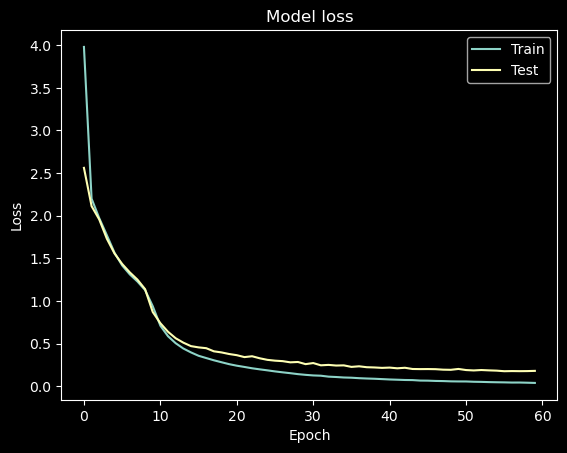

In [8]:
# Extract from the h_callback object loss and val_loss to plot the learning curve
plot_loss(h_callback.history['loss'], h_callback.history['val_loss'])

Just by looking at the picture, do you think the learning curve shows this model is overfitting after having trained for 60 epochs?

Not quite, but this question is a tricky one! The training loss is indeed lower than the test loss, but overfitting happens when as epochs go by the test loss gets worse (higher) because of the model starting to lose generalization power.

This graph doesn't show overfitting but convergence. It looks like your model has learned all it could from the data and it no longer improves. The test loss, although higher than the training loss, is not getting worse, so we aren't overfitting to the training data.

### Do we need more data?

It's time to check whether the digits dataset model you built benefits from more training examples!

In order to keep code to a minimum, various things are already initialized and ready to use:

* The model you just built.
* X_train,y_train,X_test, and y_test.
* The initial_weights of your model, saved after using model.get_weights().
* A pre-defined list of training sizes: training_sizes.
* A pre-defined early stopping callback monitoring loss: early_stop.
* Two empty lists to store the evaluation results: train_accs and test_accs.

Train your model on the different training sizes and evaluate the results on X_test. End by plotting the results with plot_results().

The full code for this exercise can be found on the slides!

In [9]:
def plot_results(train_accs,test_accs):
    plt.plot(training_sizes, train_accs, 'o-', label="Training Accuracy")
    plt.plot(training_sizes, test_accs, 'o-', label="Test Accuracy")
    plt.title('Accuracy vs Number of training samples')
    plt.xlabel('# of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc="best")
    plt.show()

In [10]:
# Instantiate a Sequential model
model = Sequential()
# Input and hidden layer with input_shape, 16 neurons, and relu 
model.add(Dense(16, input_shape = (8*8,), activation = 'relu'))
# Output layer with 10 neurons (one per digit) and softmax
model.add(Dense(10, activation='softmax'))
# Compile your model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

17/17 [==============================] - 0s 705us/step - loss: 0.1406 - accuracy: 0.9556


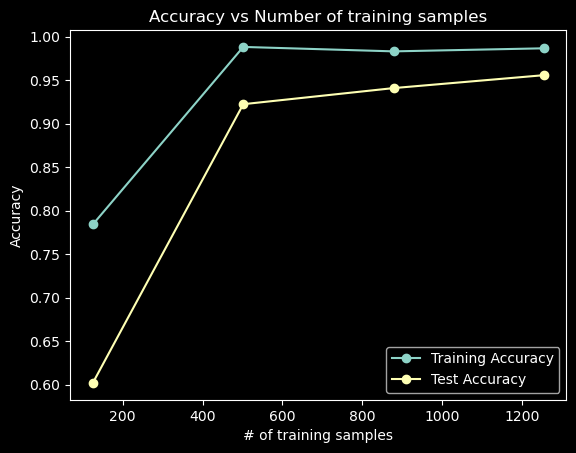

In [11]:
# Import early stopping from keras callbacks
from tensorflow.keras.callbacks import EarlyStopping
# Instantiate an early stopping callback
early_stop = EarlyStopping(monitor='loss', patience=5)
    
# Store initial model weights
initial_weights = model.get_weights()

# Lists for storing accuracies
train_accs = []
test_accs = []

training_sizes = np.array([ 125,  502,  879, 1255])

for size in training_sizes:
  	# Split a fraction according to train_size
    X_train_frac, _, y_train_frac, _ = train_test_split(X_train, y_train, train_size=size)

    # Reset the model to the initial weights and train it on the new training data fraction
    model.set_weights(initial_weights)
    model.fit(X_train_frac, y_train_frac, epochs = 50, callbacks = [early_stop], verbose=0)

    # Evaluate and store both: the training data fraction and the complete test set results
    train_accs.append(model.evaluate(X_train_frac, y_train_frac)[1])
    test_accs.append(model.evaluate(X_test, y_test)[1])
    
# Plot train vs test accuracies
plot_results(train_accs, test_accs)

Good job, that was a lot of code to understand! The results shows that your model would not benefit a lot from more training data, since the test set accuracy is already starting to flatten.

# Activation functions

## Which activation function to use?

All activation functions come with their pros and cons. There's no easy way to determine which activation function is best to use. Based on their properties, the problem at hand,and the layer we are looking at in our network, one activation function will perform better in terms of achieving our goal. A way to go is to start with ReLU as they train fast and will tend to generalize well to most problems,avoid sigmoids,and tune with experimentation. 

* No magic formula
* Different properties
* Depends on our problem
* Goal to achieve in a given layer
* ReLU are a good first choice
* Sigmoids not recommended for deep models
* Tune with experimentation

## Comparing activation functions

    # Set a random seed
    np.random.seed(1)
    # Return a new model with the given activation
    def get_model(act_function):
        model = Sequential()
        model.add(Dense(4, input_shape=(2,), activation=act_function))
        model.add(Dense(1, activation='sigmoid'))
        return model

    # Activation functions to try out
    activations = ['relu', 'sigmoid', 'tanh']
    # Dictionary to store results
    activation_results = {}
    for funct in activations:
        model = get_model(act_function=funct)
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=0)
        activation_results[funct] = history

    import pandas as pd
    # Extract val_loss history of each activation function
    val_loss_per_funct = {k:v.history['val_loss'] for k,v in activation_results.items()}
    # Turn the dictionary into a pandas dataframe
    val_loss_curves = pd.DataFrame(val_loss_per_funct)
    # Plot the curves
    val_loss_curves.plot(title='Loss per Activation function')

## Exercises

### Different activation functions

In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def tanh(x):
    return np.tanh(x)
def ReLU(x):
    return np.maximum(0.0, x)
def leaky_ReLU(x,alpha=0.01):
    return np.maximum(alpha*x, x)

The sigmoid(),tanh(), ReLU(), and leaky_ReLU() functions have been defined and ready for you to use. Each function receives an input number X and returns its corresponding Y value.

Which of the statements below is false?

The sigmoid() takes a value of 0.5 when X = 0 whilst tanh() takes a value of 0: **TRUE**

In [13]:
X = 0
sigmoid(X), tanh(X)

(0.5, 0.0)

The leaky_ReLU() takes a value of -0.01 when X = -1 whilst ReLU() takes a value of 0: **TRUE**

In [14]:
X = -1
leaky_ReLU(X), ReLU(X)

(-0.01, 0.0)

The sigmoid() and tanh() both take values close to -1 for big negative numbers: **FALSE**

In [15]:
X = -10
sigmoid(X), tanh(X)

(4.5397868702434395e-05, -0.9999999958776927)

### Comparing activation functions

Comparing activation functions involves a bit of coding, but nothing you can't do!

You will try out different activation functions on the multi-label model you built for your farm irrigation machine in chapter 2. The function get_model('relu') returns a copy of this model and applies the 'relu' activation function to its hidden layer.

You will loop through several activation functions, generate a new model for each and train it. By storing the history callback in a dictionary you will be able to visualize which activation function performed best in the next exercise!

X_train, y_train, X_test, y_test are ready for you to use when training your models.

In [16]:
sensors = pd.read_csv('irrigation_machine.csv', index_col=0)

In [17]:
# Set a random seed
np.random.seed(1)
# Return a new model with the given activation
def get_model(act_function):
    model = Sequential()
    model.add(Dense(64, input_shape=(20,), activation=act_function))
    model.add(Dense(3, activation='sigmoid'))
    model.compile(optimizer='adam',
           loss = 'binary_crossentropy',
           metrics=['accuracy'])
    return model

In [18]:
X_train, X_test, y_train, y_test = train_test_split(sensors.select_dtypes('float64'), sensors.select_dtypes('int64'), test_size=600)

In [19]:
# Activation functions to try
activations = ['relu', 'leaky_relu', 'sigmoid', 'tanh']
# Loop over the activation functions
activation_results = {}
for act in activations:
    # Get a new model with the current activation
    model = get_model(act)
    # Fit the model and store the history results
    h_callback = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=0)
    activation_results[act] = h_callback

In [20]:
activation_results

{'relu': <keras.callbacks.History at 0x7f8e30105880>,
 'leaky_relu': <keras.callbacks.History at 0x7f8e1c45af40>,
 'sigmoid': <keras.callbacks.History at 0x7f8e1c307a90>,
 'tanh': <keras.callbacks.History at 0x7f8e1c224c70>}

In [21]:
val_loss_per_function = {act: hist.history['val_loss'] for act, hist in activation_results.items()}
val_acc_per_function = {act: hist.history['val_accuracy'] for act, hist in activation_results.items()}

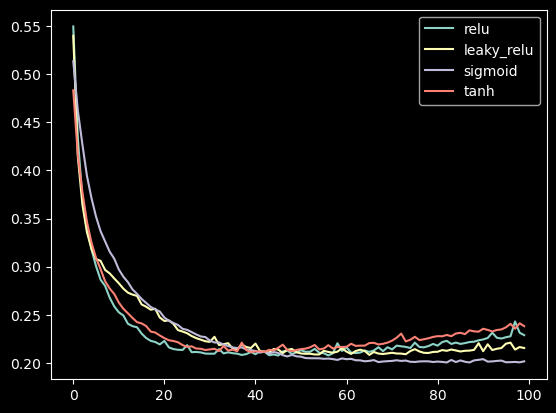

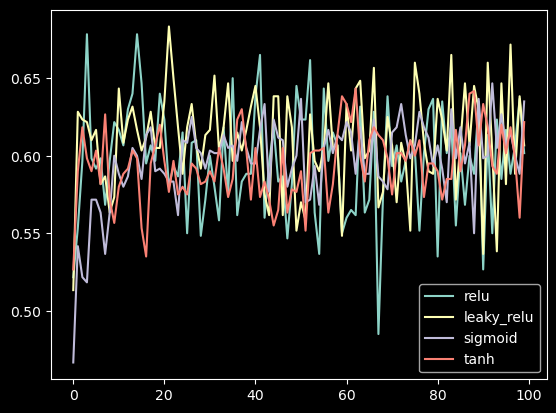

In [22]:
# Create a dataframe from val_loss_per_function
val_loss= pd.DataFrame(val_loss_per_function)

# Call plot on the dataframe
val_loss.plot()
plt.show()

# Create a dataframe from val_acc_per_function
val_acc = pd.DataFrame(val_acc_per_function)

# Call plot on the dataframe
val_acc.plot()
plt.show()

It looks like sigmoid activation worked best for this particular model as the hidden layer's activation function. It led to a model with lower validation loss and higher accuracy after 100 epochs.

# Batch size and batch normalization

## Mini-batches
* Advantages
    * Networks train faster (more weight updates in same amount of time)
    * Less RAM memory required, can train on huge datasets
    * Noise produced by a small batch-size can help escape local minima letting networks reach a lower error.
* Disadvantages
    * More iterations need to be run
    * Need to be adjusted, we need to find a good batch size

## Batch normalization advantages
* Improves gradient flow
* Allows higher learning rates
* Reduces dependence on weight initializations
* Acts as an unintended form of regularization
* Limits internal covariate shift which is a funny name for a layer's dependence on the previous layer outputs when learning its weights. 

## Batch normalization in Keras

In [23]:
# Import BatchNormalization from keras layers
from tensorflow.keras.layers import BatchNormalization
# Instantiate a Sequential model
model = Sequential()
# Add an input layer
model.add(Dense(3, input_shape=(2,), activation = 'relu'))
# Add batch normalization for the outputs of the layer above
model.add(BatchNormalization())
# Add an output layer
model.add(Dense(1, activation='sigmoid'))

## Exercises

### Changing batch sizes

You've seen models are usually trained in batches of a fixed size. The smaller a batch size, the more weight updates per epoch, but at a cost of a more unstable gradient descent. Specially if the batch size is too small and it's not representative of the entire training set.

Let's see how different batch sizes affect the accuracy of a simple binary classification model that separates red from blue dots.

You'll use a batch size of one, updating the weights once per sample in your training set for each epoch. Then you will use the entire dataset, updating the weights only once per epoch.

In [24]:
def get_model():
    model = Sequential()
    model.add(Dense(4,input_shape=(2,),activation='relu'))
    model.add(Dense(1,activation="sigmoid"))
    model.compile('sgd', 'binary_crossentropy', metrics=['accuracy'])
    return model

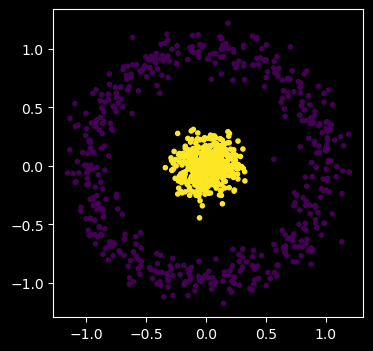

In [25]:
from sklearn.datasets import make_circles
coordinates, labels = make_circles(1000, factor=0.1, noise=0.1)
df=pd.DataFrame(dict(x=coordinates[:,0], y=coordinates[:,1], label=labels))
plt.figure(figsize=(4,4))
_ = plt.scatter(df.x, df.y, c=df.label, marker='.')

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[['x', 'y']], df['label'], test_size=.3)

In [27]:
# Get a fresh new model with get_model
model = get_model()

# Train your model for 5 epochs with a batch size of 1
model.fit(X_train, y_train, epochs=5, batch_size=1)
print("\n The accuracy when using a batch of size 1 is: ",
      model.evaluate(X_test, y_test)[1])

Epoch 1/5
700/700 [==============================] - 1s 561us/step - loss: 0.7433 - accuracy: 0.3086
Epoch 2/5
700/700 [==============================] - 0s 558us/step - loss: 0.6464 - accuracy: 0.5971
Epoch 3/5
700/700 [==============================] - 0s 561us/step - loss: 0.6031 - accuracy: 0.7057
Epoch 4/5
700/700 [==============================] - 0s 552us/step - loss: 0.5760 - accuracy: 0.7157
Epoch 5/5
10/10 [==============================] - 0s 794us/step - loss: 0.5642 - accuracy: 0.7233

 The accuracy when using a batch of size 1 is:  0.7233333587646484


**Now train a new model with batch_size equal to the size of the training set.**

In [28]:
model = get_model()

# Fit your model for 5 epochs with a batch of size the training set
model.fit(X_train, y_train, epochs=5, batch_size=X_train.shape[0])
print("\n The accuracy when using the whole training set as batch-size was: ",
      model.evaluate(X_test, y_test)[1])

Epoch 1/5
1/1 [==============================] - 0s 105ms/step - loss: 0.6093 - accuracy: 0.5000
Epoch 2/5
1/1 [==============================] - 0s 1ms/step - loss: 0.6091 - accuracy: 0.5157
Epoch 3/5
1/1 [==============================] - 0s 1ms/step - loss: 0.6090 - accuracy: 0.5229
Epoch 4/5
1/1 [==============================] - 0s 1ms/step - loss: 0.6088 - accuracy: 0.5371
Epoch 5/5
10/10 [==============================] - 0s 631us/step - loss: 0.6080 - accuracy: 0.5400

 The accuracy when using the whole training set as batch-size was:  0.5400000214576721


You can see that accuracy is lower when using a batch size equal to the training set size.

This is not because the network had more trouble learning the optimization function: Even though the same number of epochs were used for both batch sizes the number of resulting weight updates was very different!

With a batch of size the training set and 5 epochs we only get 5 updates total, each update computes and averaged gradient descent with all the training set observations.

To obtain similar results with this batch size we should increase the number of epochs so that more weight updates take place.

### Batch normalizing a familiar model

Remember the digits dataset you trained in the first exercise of this chapter?

A multi-class classification problem that you solved using softmax and 10 neurons in your output layer.

You will now build a new deeper model consisting of 3 hidden layers of 50 neurons each, using batch normalization in between layers. The kernel_initializer parameter is used to initialize weights in a similar way.

In [29]:
digits = load_digits()
X = pd.DataFrame(digits['data'], columns=digits['feature_names'])
y = pd.DataFrame(to_categorical(digits['target']), columns=digits['target_names'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [30]:
# Build your deep network
batchnorm_model = Sequential()
batchnorm_model.add(Dense(50, input_shape=(64,), activation='relu', kernel_initializer='normal'))
batchnorm_model.add(BatchNormalization())
batchnorm_model.add(Dense(50, activation='relu', kernel_initializer='normal'))
batchnorm_model.add(BatchNormalization())
batchnorm_model.add(Dense(50, activation='relu', kernel_initializer='normal'))
batchnorm_model.add(BatchNormalization())
batchnorm_model.add(Dense(10, activation='softmax', kernel_initializer='normal'))

# Compile your model with sgd
batchnorm_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
batchnorm_model.summary(line_length=120)

Model: "sequential_9"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 dense_18 (Dense)                                     (None, 50)                                      3250              
                                                                                                                        
 batch_normalization_1 (BatchNormalization)           (None, 50)                                      200               
                                                                                                                        
 dense_19 (Dense)                                     (None, 50)                                      2550              
                                                                                                                        
 batch_nor

### Batch normalization effects

Batch normalization tends to increase the learning speed of our models and make their learning curves more stable. Let's see how two identical models with and without batch normalization compare.

The model you just built batchnorm_model is loaded for you to use. An exact copy of it without batch normalization: standard_model, is available as well. You can check their summary() in the console. X_train, y_train, X_test, and y_test are also loaded so that you can train both models.

You will compare the accuracy learning curves for both models plotting them with compare_histories_acc().

You can check the function pasting show_code(compare_histories_acc) in the console.

In [31]:
def compare_histories_acc(h1,h2):
    plt.plot(h1.history['accuracy'])
    plt.plot(h1.history['val_accuracy'])
    plt.plot(h2.history['accuracy'])
    plt.plot(h2.history['val_accuracy'])
    plt.title("Batch Normalization Effects")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test', 'Train with Batch Normalization', 'Test with Batch Normalization'], loc='best')
    plt.show()

In [32]:
# Build your deep network
standard_model = Sequential()
standard_model.add(Dense(50, input_shape=(64,), activation='relu', kernel_initializer='normal'))
standard_model.add(Dense(50, activation='relu', kernel_initializer='normal'))
standard_model.add(Dense(50, activation='relu', kernel_initializer='normal'))
standard_model.add(Dense(10, activation='softmax', kernel_initializer='normal'))
# Compile your model with sgd
standard_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
standard_model.summary(line_length=120)

Model: "sequential_10"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 dense_22 (Dense)                                     (None, 50)                                      3250              
                                                                                                                        
 dense_23 (Dense)                                     (None, 50)                                      2550              
                                                                                                                        
 dense_24 (Dense)                                     (None, 50)                                      2550              
                                                                                                                        
 dense_25

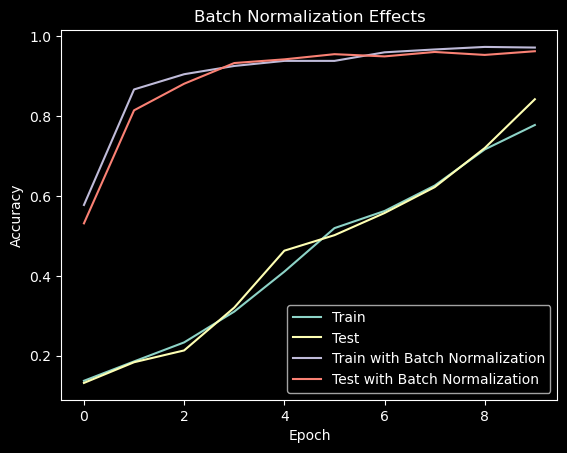

In [33]:
# Train your standard model, storing its history callback
h1_callback = standard_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=0)
# Train the batch normalized model you recently built, store its history callback
h2_callback = batchnorm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=0)
# Call compare_histories_acc passing in both model histories
compare_histories_acc(h1_callback, h2_callback)

You can see that for this deep model batch normalization proved to be useful, helping the model obtain high accuracy values just over the first 10 training epochs.

# Hyperparameter tuning

## Neural network hyperparameters
* Number of layers
* Number of neurons per layer
* Layer order
* Layer activations
* Batch sizes
* Learning rates
* Optimizers
* ...

## Sklearn recap

In [34]:
# Import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
# Instantiate your classifier
tree = DecisionTreeClassifier()
# Define a series of parameters to look over
params = {'max_depth':[3,None], "max_features":range(1,4), 'min_samples_leaf': range(1,4)}
# Perform random search with cross validation
tree_cv = RandomizedSearchCV(tree, params, cv=5)
tree_cv.fit(X,y)
# Print the best parameters
print(tree_cv.best_params_)

{'min_samples_leaf': 1, 'max_features': 2, 'max_depth': None}


## Turn a Keras model into a Sklearn estimator

In [35]:
# Function that creates our Keras model
def create_model(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dense(16, input_shape=(2,), activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Import sklearn wrapper from keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from scikeras.wrappers import KerasClassifier
# Create a model as a sklearn estimator
model = KerasClassifier(build_fn=create_model, epochs=6, batch_size=16, verbose=0,
                        #optimizer='sgd', activation='relu', loss='binary_crossentropy', metrics=['accuracy']
                       )
model.get_params()

/tmp/ipykernel_292997/3443688379.py:13: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=6, batch_size=16, verbose=0,


{'epochs': 6,
 'batch_size': 16,
 'verbose': 0,
 'build_fn': <function __main__.create_model(optimizer='adam', activation='relu')>}

## Cross-validation

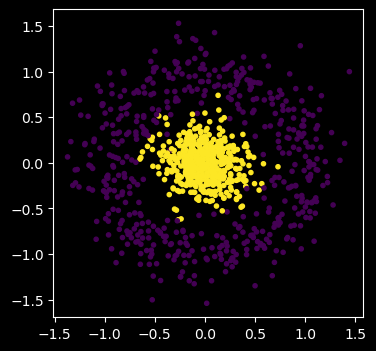

In [36]:
from sklearn.datasets import make_circles
X, y = make_circles(1000, factor=0.1, noise=0.2)
df=pd.DataFrame(dict(x=coordinates[:,0], y=coordinates[:,1], label=labels))
plt.figure(figsize=(4,4))
_ = plt.scatter(X[:,0], X[:,1], c=y, marker='.')

In [37]:
# Import cross_val_score
from sklearn.model_selection import cross_val_score
# Check how your keras model performs with 5 fold crossvalidation
kfold = cross_val_score(model, X, y, cv=5)

In [38]:
# Print the mean accuracy per fold
kfold.mean()

0.8179999947547912

In [39]:
# Print the standard deviation accuracy per fold
kfold.std()

0.09463615457558239

## Tips for neural networks hyperparameter tuning
* Random search is preferred over grid search
* Don't use many epochs
* Use a smaller sample of your dataset
* Play with batch sizes, activations, optimizers and learning rates

## Random search on Keras models

In [40]:
model = KerasClassifier(build_fn=create_model, epochs=6, batch_size=16, verbose=0,
                        activation='foo')
model.get_params()

/tmp/ipykernel_292997/3459228428.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=6, batch_size=16, verbose=0,


{'epochs': 6,
 'batch_size': 16,
 'verbose': 0,
 'activation': 'foo',
 'build_fn': <function __main__.create_model(optimizer='adam', activation='relu')>}

In [41]:
# Define a series of parameters
params = dict(optimizer=['sgd', 'adam'],
              epochs=[3],
              batch_size=[5, 10, 20],
              activation=['relu','tanh'])
# Create a random search cv object and fit it to the data
random_search = RandomizedSearchCV(model,
                                   param_distributions=params,
                                   cv=3)
random_search_results = random_search.fit(X, y)
# Print results
print("Best: {} using {}".format(random_search_results.best_score_, random_search_results.best_params_))

Best: 0.8590027292569479 using {'optimizer': 'adam', 'epochs': 3, 'batch_size': 5, 'activation': 'relu'}


## Tuning other hyperparameters

In [42]:
def create_model(nl=1, nn=256):
    model = Sequential()
    model.add(Dense(16, input_shape=(2,), activation='relu'))
    # Add as many hidden layers as specified in nl
    for i in range(nl):
        # Layers have nn neurons
        model.add(Dense(nn, activation='relu'))
    # End defining and compiling your model...
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model    

In [43]:
# Create a model as a sklearn estimator
model = KerasClassifier(build_fn=create_model, epochs=6, batch_size=16, verbose=0,
                        nl=1, nn=256,
                        # optimizer='adam',
                        # loss='binary_crossentropy',
                        # metrics=['accuracy']
                       )
print(model.get_params())

# Define parameters, named just like in create_model()
params = dict(nl=[1, 2, 9], nn=[128, 256, 1000])
# Create a random search cv object and fit it to the data
random_search = RandomizedSearchCV(model,
                                   param_distributions=params,
                                   cv=3,
                                   n_iter=9
                                  )
random_search_results = random_search.fit(X, y)

{'epochs': 6, 'batch_size': 16, 'verbose': 0, 'nl': 1, 'nn': 256, 'build_fn': <function create_model at 0x7f8e1c5bcb80>}


/tmp/ipykernel_292997/3622454060.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=6, batch_size=16, verbose=0,


In [44]:
# Print results
print("Best: {} using {}".format(random_search_results.best_score_, random_search_results.best_params_))

Best: 0.9760059515635172 using {'nn': 256, 'nl': 1}


## Exercises

### Preparing a model for tuning

Let's tune the hyperparameters of a binary classification model that does well classifying the breast cancer dataset.

You've seen that the first step to turn a model into a sklearn estimator is to build a function that creates it. The definition of this function is important since hyperparameter tuning is carried out by varying the arguments your function receives.

Build a simple create_model() function that receives both a learning rate and an activation function as arguments. The Adam optimizer has been imported as an object from tensorflow.keras.optimizers so that you can also change its learning rate parameter.

In [45]:
from sklearn.datasets import load_breast_cancer
X = load_breast_cancer()['data']
y = load_breast_cancer()['target']
X.shape, y.shape

((569, 30), (569,))

In [46]:
# Creates a model given an activation and learning rate
def create_model(learning_rate, activation):
  	# Create an Adam optimizer with the given learning rate
  	opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
  	# Create your binary classification model  
  	model = Sequential()
  	model.add(Dense(128, input_shape = (30,), activation = activation))
  	model.add(Dense(256, activation = activation))
  	model.add(Dense(1, activation = 'sigmoid'))
  	# Compile your model with your optimizer, loss, and metrics
  	model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
  	return model

With this function ready you can now create a sklearn estimator and generate different models to perform simple hyperparameter tuning on!

In [47]:
from sklearn.model_selection import KFold
# Create a KerasClassifier
model = KerasClassifier(build_fn=create_model,
                        learning_rate=None,
                        activation='foo',
                        verbose=0
                       )
model.get_params()

/tmp/ipykernel_292997/1882157052.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model,


{'learning_rate': None,
 'activation': 'foo',
 'verbose': 0,
 'build_fn': <function __main__.create_model(learning_rate, activation)>}

In [48]:
# Define the parameters to try out
params = {'activation': ['relu', 'tanh'],
          'batch_size': [32, 128, 256],
          'epochs': [50, 100, 200],
          'learning_rate': [0.1, 0.01, 0.001]}
# Create a randomize search cv object passing in the parameters to try
random_search = RandomizedSearchCV(model, param_distributions=params, cv=KFold(3))

In [49]:
random_search_results = random_search.fit(X, y)

In [50]:
# Print results
print("Best: {} using {}".format(random_search_results.best_score_, random_search_results.best_params_))

Best: 0.9384572505950928 using {'learning_rate': 0.01, 'epochs': 200, 'batch_size': 32, 'activation': 'relu'}


### Training with cross-validation

Time to train your model with the best parameters found: 0.001 for the learning rate, 50 epochs, a 128 batch_size and relu activations.

The create_model() function from the previous exercise is ready for you to use. X and y are loaded as features and labels.

Use the best values found for your model when creating your KerasClassifier object so that they are used when performing cross_validation.

End this chapter by training an awesome tuned model on the breast cancer dataset!

In [51]:
# Creates a model given an activation and learning rate
def create_model(learning_rate = None, #0.001,
                 activation = None): #'relu'):
  	# Create an Adam optimizer with the given learning rate
  	opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
  	# Create your binary classification model  
  	model = Sequential()
  	model.add(Dense(128, input_shape = (30,), activation = activation))
  	model.add(Dense(256, activation = activation))
  	model.add(Dense(1, activation = 'sigmoid'))
  	# Compile your model with your optimizer, loss, and metrics
  	model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
  	return model

In [52]:
# Create a KerasClassifier
# model = KerasClassifier(build_fn=create_model(learning_rate = 0.001, activation = 'relu'),
model = KerasClassifier(build_fn=create_model,
                        epochs=50,
                        batch_size=128,
                        verbose=0, learning_rate = 0.001, activation = 'relu')

# Calculate the accuracy score for each fold
kfolds = cross_val_score(model, X, y, cv=3)

# Print the mean accuracy
print('The mean accuracy was:', kfolds.mean())

# Print the accuracy standard deviation
print('With a standard deviation of:', kfolds.std())

/tmp/ipykernel_292997/914502835.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model,


The mean accuracy was: 0.8627216219902039
With a standard deviation of: 0.07880020016446872
